# Bigfoot Data - Collection and Cleaning
This jupyter notebook will let us scrape report urls from [The Bigfoot Field Reaserchers Organization (BFRO)](www.bfro.net) and convert them into a structured dataframe. After standard cleaning procedures, the cleaned DataFrame will be saved. 
## Part I: Data Collection
We are collecting Bigfoot sighting data from the BFRO, a group that has been documenting reports since 1995. This extensive collection of entries will provide a robust dataset for exploration. The BFRO considers itself the only *scientific* Bigfoot research group, and therefore holds itself to a high research standard which is reflected in the quality and consistency of reports. This structure will be key to a streamlined scraping process. 

In [2]:
# Import Dependencies
import requests
from bs4 import BeautifulSoup
import logging
import pandas as pd
import json
import matplotlib.pyplot as plt

In [ ]:

bigfoot_url = 'https://www.bfro.net/'

# Configure logging
logging.basicConfig(
    filename='notebooks/logs/bigfoot_scraper.log',  # Log file name
    filemode='a',  # Append mode
    level=logging.DEBUG,  # Log everything from DEBUG and above
    format='%(asctime)s - %(levelname)s - %(message)s'
)

In [ ]:
def soupify_website(url):
    """
    Fetches the HTML content of a given URL and parses it into a BeautifulSoup object.

    Parameters:
        url (str): The URL of the webpage to be scraped.

    Returns:
        BeautifulSoup: A BeautifulSoup object representing the parsed HTML of the webpage.
    
    Raises:
        ValueError: If the HTTP response status is not 200(OK)
    """
    
    # test connection
    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        return soup
    else:
        raise ValueError(f"Failed to fetch {url}: Status code {response.status_code}")

def get_links(soup_list):
    """
    Extracts all hyperlinks from a list of BeautifulSoup objects.

    Parameters:
        soup_list (list): A list of BeautifulSoup objects to search for links.

    Returns:
        list: A list of hyperlink strings (`href` values) extracted from the provided BeautifulSoup objects.
    
    Notes:
        - Only links with an `href` attribute will be included.
        - Duplicate links are not removed; the returned list may contain duplicates.
    """
    link_list = []
    for soup in soup_list:
        links = soup.find_all('a')
        for link in links:
            if link.get('href'):
                url = link.get('href')
                link_list.append(url)
    return link_list



### Example Report: Our Content
To illustrate our scraping process, we will consider [Report #77968](https://www.bfro.net/GDB/show_report.asp?id=77968) from Douglas County Nebraska. While the sections detailing the encounter observations and follow up research are intriguing and could be useful for future expansion, for this ntoebook at least, our interest lies in those first sections of information. 
<figure>
<img src='../images/Report%2077968%20relevant%20information.png' width = 500>
<figcaption>
The relevant information from <a href="https://www.bfro.net/GDB/show_report.asp?id=77968"> Report #77968 </a> that we will be collecting.
</figcaption> 
</figure>

These sections provide key details, such as location, date, classification, and reporter. Here we are lucky as each of these sections is seperated from one another by `span` elements, making it a simple task to create a collect the desired inforrmation and store it in a dictionary for processing.

In [ ]:
def create_sighting_dictionary(url):
    """
    Extracts information from an individual report page and returns it as a dictionary.

    Parameters:
        url (str): The URL of the report page.

    Returns:
        dict: A dictionary with the extracted information, or None if the page cannot be parsed.
    """
    logging.info(f"Fetching report from: {url}")
    report = soupify_website(url)

    if not report:
        logging.error(f"Failed to parse report page: {url}")
        return None

    try:
        report_dict = {}

        # Extract 'Report Number'
        report_header = report.find('span', class_='reportheader')
        report_dict['Report Number'] = report_header.text.strip() if report_header else 'N/A'

        # Extract 'Report Classification'
        report_class = report.find('span', class_='reportclassification')
        report_dict['Report Class'] = report_class.text.strip() if report_class else 'N/A'

        # Extract additional fields
        fields = report.find_all('span', class_='field')
        for field in fields:
            # Get the full text of the parent element
            text = field.parent.text.strip()

            # Only process fields in the format "Header: Value"
            if ':' in text:
                # Split into field name and value
                field_name, value = text.split(':', 1)

                # Clean up field name and value
                field_name = field_name.strip().lower()
                value = value.strip()

                # Validate input (ensure no line breaks in the value)
                if len(value.split('\n')) == 1:
                    # Store the field and value in the dictionary
                    report_dict[field_name] = value

        return report_dict

    except Exception as e:
        logging.error(f"Error processing report {url}: {e}")
        return None

### Getting the Reports
The path to each Bigfoot sighting listing follows a structured hierarchy: GDB/State/County/Listing.
- The GDB (Geographic Database of Bigfoot Sightings and Reports) serves as the starting point. It contains several tables, each linking to a state (or province, etc.) page.
- Each state page features similar tables that provide links to county pages.
- County pages only exist if there are recorded Bigfoot sightings in that county. These pages link to the county's sighting listings.
- Finally, county sightings pages list all recorded sightings for that county, with links and short descriptions for each report.

Having created the function to extract data from individual listings, we will now work in reverse of the above heiarchy. 

In [ ]:
def scrape_county(url):
    """
    Scrapes all report URLs from a county sightings page.

    Parameters:
        url (str): The URL of the county sightings page to scrape.

    Returns:
        list: A list of dictionaries containing data from individual Bigfoot sighting reports.
    """
    logging.info(f"Starting to scrape county page: {url}")
    report_dictionaries = []
    base_url = 'https://www.bfro.net/GDB/'

    # Fetch the county page
    county_soup = soupify_website(url)
    if not county_soup:
        logging.error(f"Failed to fetch or parse county page: {url}")
        return report_dictionaries

    # Find all report links on the county page
    county_reports = county_soup.find_all('span', class_='reportcaption')
    report_urls = get_links(county_reports)
    logging.info(f"Found {len(report_urls)} reports on county page: {url}")

    # Process each report URL
    for report_url in report_urls:
        full_url = base_url + report_url
        try:
            logging.debug(f"Scraping report: {full_url}")
            report_dict = create_sighting_dictionary(full_url)
            if report_dict:
                report_dictionaries.append(report_dict)
            else:
                logging.warning(f"No data extracted for report: {full_url}")
        except Exception as e:
            logging.error(f"Error scraping report {full_url}: {e}")

    logging.info(f"Finished scraping county page: {url}")
    return report_dictionaries


In [ ]:
# Testing with Douglas County NE, should have 3 listings as of 12/3/2024
county_url = 'https://www.bfro.net/GDB/show_county_reports.asp?state=NE&county=Douglas'
sighting_url = 'https://www.bfro.net/GDB/'
my_reports = scrape_county(county_url)
print(f"Douglass County has has {len(my_reports)} sightings")
print("Printing sighting dictionaries:")
for report in my_reports:
    print(report)
    

In [ ]:
def scrape_state(state_url):
    state_soup = soupify_website(state_url)
    tables = state_soup.find_all('table', class_='countytbl')

    county_links = get_links(tables)

    state_reports = []

    for link in county_links:
        sighting_links = scrape_county(sighting_url+link)
        for sighting in sighting_links:
            state_reports.append(sighting)
    return state_reports           

In [ ]:
gdb_soup = soupify_website('https://www.bfro.net/GDB')
gdb_tables = gdb_soup.find_all('table', class_='countytbl')
state_urls = [x for x in get_links(gdb_tables) if 'state=int' not in x]

### The Big Show
It's time to combine our functions to pull every report from the GDB. This is several 
thousand pages and will take a while so I included logging so that you can see how far the
code has proceeded. 

In [ ]:
all_reports = []

for url in state_urls:
    full_url = 'https://www.bfro.net' + url
    logging.info(f"Scraping state page: {full_url}")
    try:
        # Scrape the state page for reports
        state_dicts = scrape_state(full_url)

        # Append each report dictionary to the master list
        all_reports.extend(state_dicts)

    except Exception as e:
        logging.error(f"Error scraping state page {full_url}: {e}")


In [ ]:
print(f"We found a total of {len(all_reports)} entries.")
print(all_reports[:2]) # preview the first two entries 

# Save the data that was pulled
with open("../data/raw_scraping_data.json", "w") as file:
    json.dump(all_reports, file)

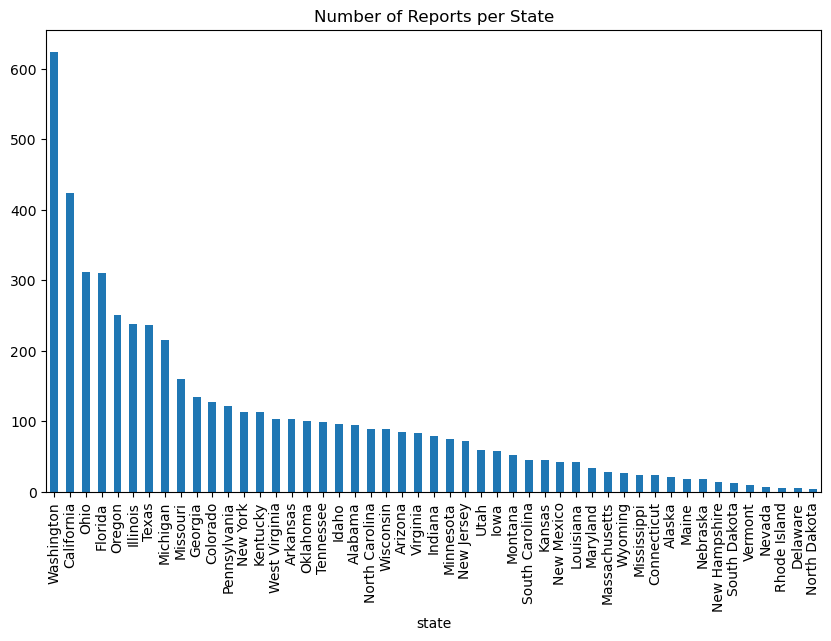

In [4]:
state_counts = all_reports['state'].value_counts()
state_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Reports per State')
plt.show()

## Conclusion
We successfully scraped 5000+ Bigfoot sightings from the BFRO database. The data will be cleaned and analyzed in the next step to explore geographic and temporal trends.
